# 一维算例

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.sin(X - T)
        b = np.cos(X + T)
        c = np.sin(X + T)
        d = np.cos(X - T)
        
        # 计算梯度
        dx = x[1] - x[0]
        a_grad_x, a_grad_y = np.gradient(a, dx, dx)
        b_grad_x, b_grad_y = np.gradient(b, dx, dx)
        c_grad_x, c_grad_y = np.gradient(c, dx, dx)
        d_grad_x, d_grad_y = np.gradient(d, dx, dx)
        
        # 根据公式计算u
        u = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
        data.append((u, np.stack((a, b, c, d), axis=0)))
    return data


In [13]:
def compute_u(a, b, c, d, dx):
    # 计算梯度
    a_grad_x, a_grad_y = np.gradient(a, dx, dx)
    b_grad_x, b_grad_y = np.gradient(b, dx, dx)
    c_grad_x, c_grad_y = np.gradient(c, dx, dx)
    d_grad_x, d_grad_y = np.gradient(d, dx, dx)
    
    # 根据公式计算u
    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    u_pre = u_pre_x + u_pre_y
    return u_pre

In [17]:
# 准备训练和测试数据
num_samples = 2000
size = 32  # 调整分辨率为 32x32
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data


In [18]:
# 自定义数据集
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)


In [19]:
train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
# 模型定义
class VelocityPredictor(nn.Module):
    def __init__(self, size):
        super(VelocityPredictor, self).__init__()
        self.size = size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * size * size, 512)  # 128 channels * size * size
        self.fc2 = nn.Linear(512, 4 * size * size)    # 4 channels * size * size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, self.size, self.size)  # Reshape the output tensor
        return x


In [9]:
# 计算速度场
def compute_velocity(a, b, c, d):
    dx = 1.0 / a.size(-1)  # 假设均匀网格
    a_grad_x, a_grad_y = torch.gradient(a, spacing=(dx, dx), dim=(1, 2))
    b_grad_x, b_grad_y = torch.gradient(b, spacing=(dx, dx), dim=(1, 2))
    c_grad_x, c_grad_y = torch.gradient(c, spacing=(dx, dx), dim=(1, 2))
    d_grad_x, d_grad_y = torch.gradient(d, spacing=(dx, dx), dim=(1, 2))

    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    return u_pre_x + u_pre_y


In [20]:
# 训练模型
num_epochs = 50
model = VelocityPredictor(size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [21]:
for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :].requires_grad_(True)
        b = outputs[:, 1, :, :].requires_grad_(True)
        c = outputs[:, 2, :, :].requires_grad_(True)
        d = outputs[:, 3, :, :].requires_grad_(True)
        
        u_pred = compute_velocity(a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/50, Loss: 0.000839399581309408
Epoch 2/50, Loss: 0.002443659817799926
Epoch 3/50, Loss: 5.231105660641333e-06
Epoch 4/50, Loss: 0.002943355357274413
Epoch 5/50, Loss: 8.630773891127319e-07
Epoch 6/50, Loss: 2.7283465442451416e-07
Epoch 7/50, Loss: 1.5001502617906226e-07
Epoch 8/50, Loss: 0.01058503333479166
Epoch 9/50, Loss: 6.4577848206681665e-06
Epoch 10/50, Loss: 9.323433403096715e-08
Epoch 11/50, Loss: 5.539097713835872e-08
Epoch 12/50, Loss: 3.831025097156271e-08
Epoch 13/50, Loss: 2.65476014504884e-08
Epoch 14/50, Loss: 1.8163271775506473e-08
Epoch 15/50, Loss: 1.2204533383908256e-08
Epoch 16/50, Loss: 8.039198640119594e-09
Epoch 17/50, Loss: 5.184068285757348e-09
Epoch 18/50, Loss: 0.02177310362458229
Epoch 19/50, Loss: 6.140931418485707e-06
Epoch 20/50, Loss: 2.0852536408710876e-07
Epoch 21/50, Loss: 1.050681248671026e-07
Epoch 22/50, Loss: 5.6883585841660533e-08
Epoch 23/50, Loss: 3.039264839799216e-08
Epoch 24/50, Loss: 1.5868591773937624e-08
Epoch 25/50, Loss: 8.0734

In [22]:
# 测试模型
model.eval()

VelocityPredictor(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4096, bias=True)
)

In [23]:
with torch.no_grad():
    test_targets = []
    test_predictions = []
    a_predictions = []
    b_predictions = []
    c_predictions = []
    d_predictions = []
    
    for u, params in test_loader:
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())
        
        a_predictions.append(a.numpy())
        b_predictions.append(b.numpy())
        c_predictions.append(c.numpy())
        d_predictions.append(d.numpy())

    if test_targets:
        test_targets = np.concatenate(test_targets)
        test_predictions = np.concatenate(test_predictions)
    else:
        test_targets = np.array(test_targets)
        test_predictions = np.array(test_predictions)

    if a_predictions:
        a_predictions = np.concatenate(a_predictions)
        b_predictions = np.concatenate(b_predictions)
        c_predictions = np.concatenate(c_predictions)
        d_predictions = np.concatenate(d_predictions)
    else:
        a_predictions = np.array(a_predictions)
        b_predictions = np.array(b_predictions)
        c_predictions = np.array(c_predictions)
        d_predictions = np.array(d_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')

Test Mean Squared Error: 1.2099559025600774e-14
Test Mean Absolute Error: 7.224415554674124e-08
Test R^2 Score: 1.0


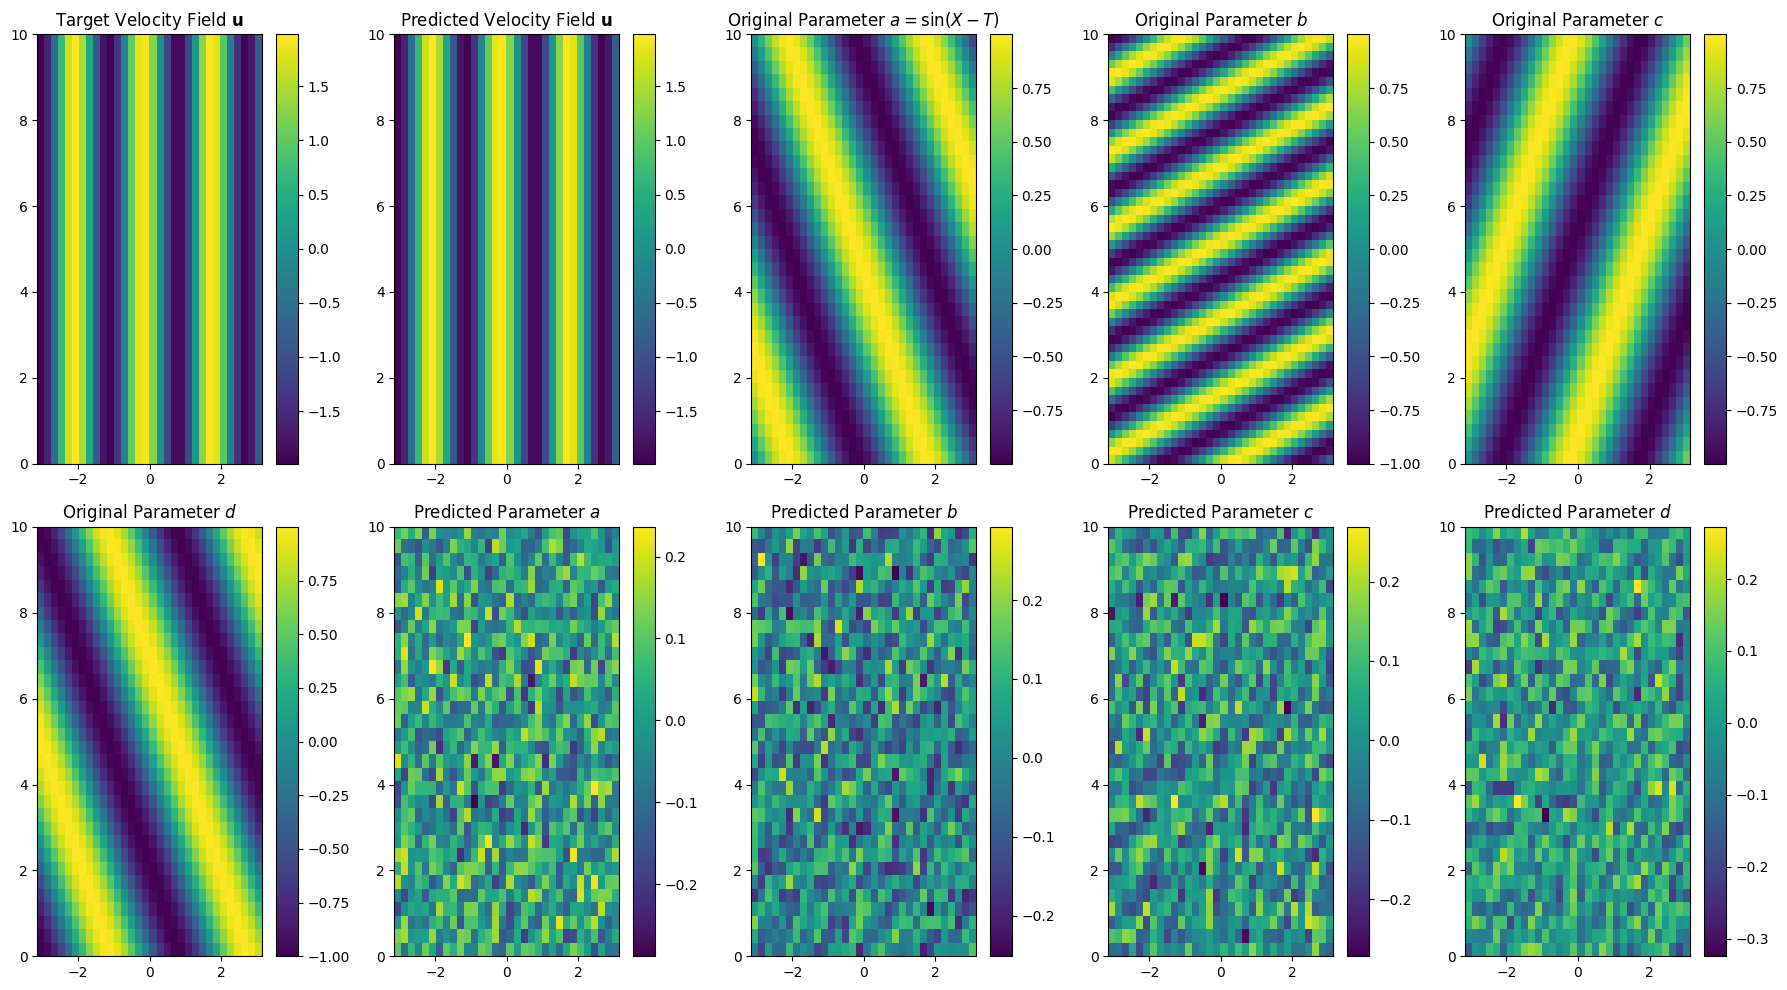

In [24]:
# 可视化结果
plt.figure(figsize=(18, 10))

# 绘制目标速度场
plt.subplot(2, 5, 1)
if test_targets.size > 0:
    plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(2, 5, 2)
if test_predictions.size > 0:
    plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Velocity Field $\\mathbf{u}$')

# 绘制原始和预测的 a 参数对比图
plt.subplot(2, 5, 3)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $a = \sin(X - T)$')

plt.subplot(2, 5, 7)
if a_predictions.size > 0:
    plt.imshow(a_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $a$')

# 绘制原始和预测的 b 参数对比图
plt.subplot(2, 5, 4)
plt.imshow(np.cos(np.linspace(-np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $b$')

plt.subplot(2, 5, 8)
if b_predictions.size > 0:
    plt.imshow(b_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $b$')

# 绘制原始和预测的 c 参数对比图
plt.subplot(2, 5, 5)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $c$')

plt.subplot(2, 5, 9)
if c_predictions.size > 0:
    plt.imshow(c_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $c$')

# 绘制原始和预测的 d 参数对比图
plt.subplot(2, 5, 6)
plt.imshow(np.cos(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $d$')

plt.subplot(2, 5, 10)
if d_predictions.size > 0:
    plt.imshow(d_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $d$')

plt.tight_layout()
plt.show()

In [74]:
aPre = a_predictions[0].squeeze().copy()
bPre = b_predictions[0].squeeze().copy()
cPre = c_predictions[0].squeeze().copy()
dPre = d_predictions[0].squeeze().copy()


In [76]:
u111 =  compute_u(aPre, bPre, cPre, dPre, dx)
plt.imshow(u111, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

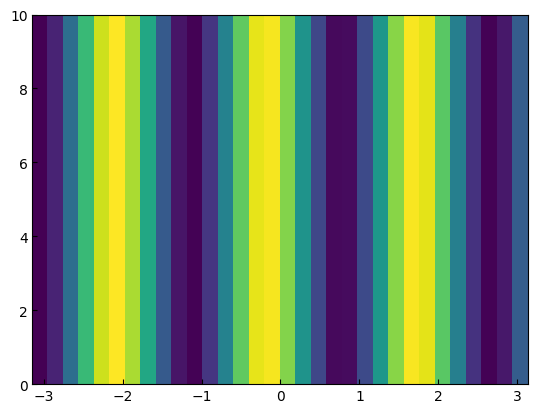

In [77]:
plt.imshow(u111, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

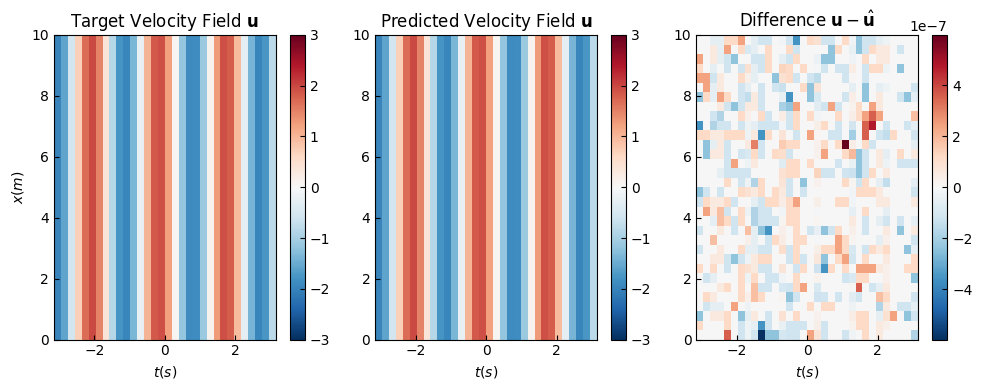

In [60]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)

plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='nearest',vmin=-3, vmax=3)
plt.colorbar()
plt.xlabel('$t(s)$')
plt.ylabel('$x(m)$')
plt.title('Target Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 2)
plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='nearest',vmin=-3, vmax=3)
plt.colorbar()
plt.xlabel('$t(s)$')
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 3)
plt.imshow(test_targets[0].squeeze() - test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='nearest')
plt.xlabel('$t(s)$')
plt.colorbar()
plt.title('Difference $\\mathbf{u} - \\hat{\\mathbf{u}}$')


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tight_layout()
plt.savefig('result/velocity_field.png', dpi=300)
plt.show()



In [57]:
aCopy = a_predictions[0].squeeze().copy()
bCopy = b_predictions[0].squeeze().copy()
cCopy = c_predictions[0].squeeze().copy()
dCopy = d_predictions[0].squeeze().copy()

aCopy.shape, bCopy.shape, cCopy.shape, dCopy.shape

NameError: name 'a_predictions' is not defined

In [58]:
np.save('aCopy717.npy', aCopy)
np.save('bCopy717.npy', bCopy)
np.save('cCopy717.npy', cCopy)
np.save('dCopy717.npy', dCopy)

In [59]:
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")

超分辨过程

## 传统算法

In [60]:
from scipy.ndimage import zoom

In [84]:
# 定义一个函数进行双三次插值
def bicubic_interpolation(data, scale_factor):
    return zoom(data, scale_factor, order=3)


In [85]:
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")

In [86]:
# 设置放大因子
scale_factor = 4

# 对每组数据进行双三次插值
a_high_res = bicubic_interpolation(aCopy, scale_factor)
b_high_res = bicubic_interpolation(bCopy, scale_factor)
c_high_res = bicubic_interpolation(cCopy, scale_factor)
d_high_res = bicubic_interpolation(dCopy, scale_factor)


In [87]:
# 确认高分辨率数据的形状
print("a_high_res shape:", a_high_res.shape)
print("b_high_res shape:", b_high_res.shape)
print("c_high_res shape:", c_high_res.shape)
print("d_high_res shape:", d_high_res.shape)


a_high_res shape: (128, 128)
b_high_res shape: (128, 128)
c_high_res shape: (128, 128)
d_high_res shape: (128, 128)


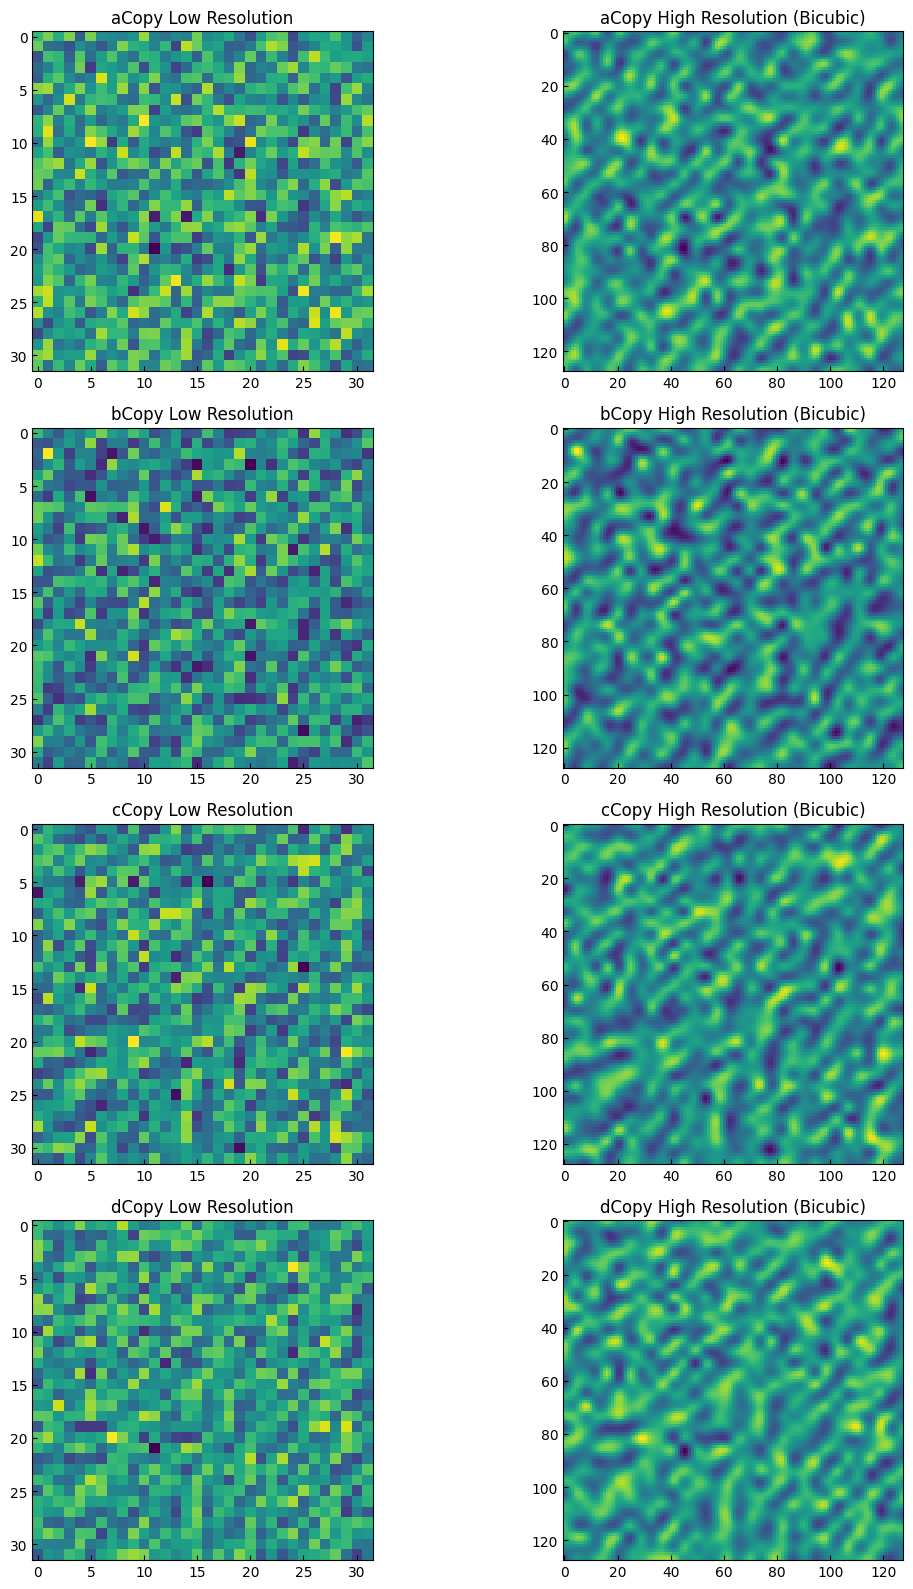

In [88]:
# 可视化对比
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# 绘制原始低分辨率图像
axs[0, 0].imshow(aCopy, cmap='viridis', interpolation='none')
axs[0, 0].set_title('aCopy Low Resolution')
axs[1, 0].imshow(bCopy, cmap='viridis', interpolation='none')
axs[1, 0].set_title('bCopy Low Resolution')
axs[2, 0].imshow(cCopy, cmap='viridis', interpolation='none')
axs[2, 0].set_title('cCopy Low Resolution')
axs[3, 0].imshow(dCopy, cmap='viridis', interpolation='none')
axs[3, 0].set_title('dCopy Low Resolution')

# 绘制双三次插值后的高分辨率图像
axs[0, 1].imshow(a_high_res, cmap='viridis', interpolation='none')
axs[0, 1].set_title('aCopy High Resolution (Bicubic)')
axs[1, 1].imshow(b_high_res, cmap='viridis', interpolation='none')
axs[1, 1].set_title('bCopy High Resolution (Bicubic)')
axs[2, 1].imshow(c_high_res, cmap='viridis', interpolation='none')
axs[2, 1].set_title('cCopy High Resolution (Bicubic)')
axs[3, 1].imshow(d_high_res, cmap='viridis', interpolation='none')
axs[3, 1].set_title('dCopy High Resolution (Bicubic)')

plt.tight_layout()
plt.show()

In [89]:
a_high_res.shape, b_high_res.shape, c_high_res.shape, d_high_res.shape

((128, 128), (128, 128), (128, 128), (128, 128))

In [90]:
sizeLow = 32
xlow = np.linspace(-np.pi, np.pi, sizeLow)
tlow = np.linspace(0, 10, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 128
xHigh = np.linspace(-np.pi, np.pi, sizehigh)
tHigh = np.linspace(0, 10, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [91]:
u_low = compute_u(aCopy, bCopy, cCopy, dCopy, dxLow)


u_high = compute_u(a_high_res, b_high_res, c_high_res, d_high_res, dxHigh)

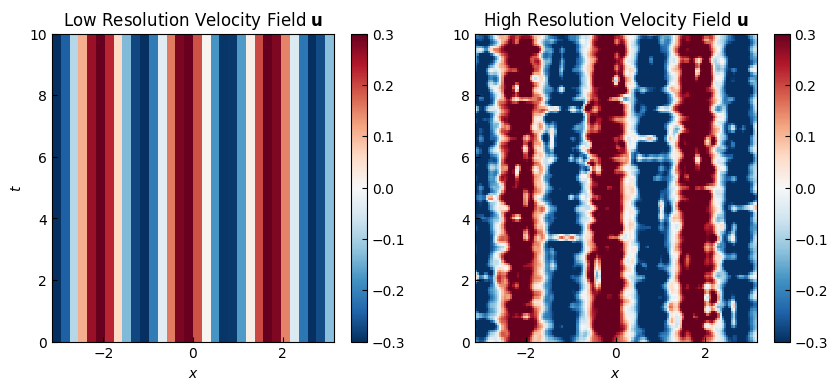

In [93]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Low Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.title('High Resolution Velocity Field $\\mathbf{u}$')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.savefig('result/velocity_field_One_High', dpi=300)

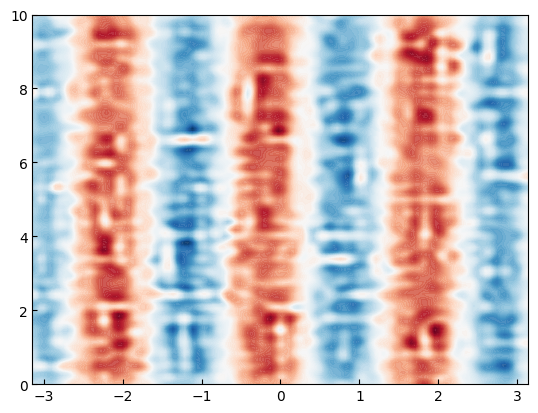

In [80]:
# plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.contourf(xHigh, tHigh, u_high, 100, cmap='RdBu_r', alpha=0.9)
# plt.savefig('result/velocity_field_high_res.png', dpi=300)

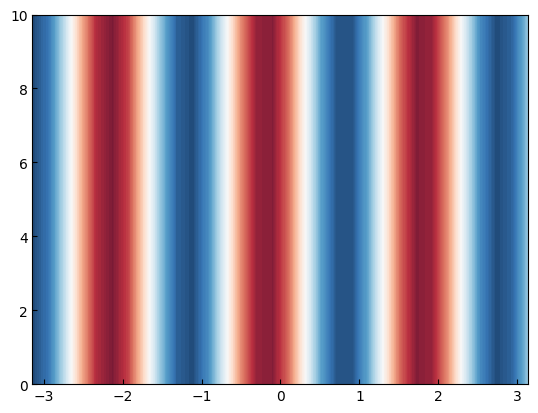

In [79]:
# plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.contourf(xlow, tlow, u_low, 100, cmap='RdBu_r', alpha=0.9)
# plt.savefig('result/velocity_field_low_res.png', dpi=300)

a_high_res shape: (128, 128)
b_high_res shape: (128, 128)
c_high_res shape: (128, 128)
d_high_res shape: (128, 128)


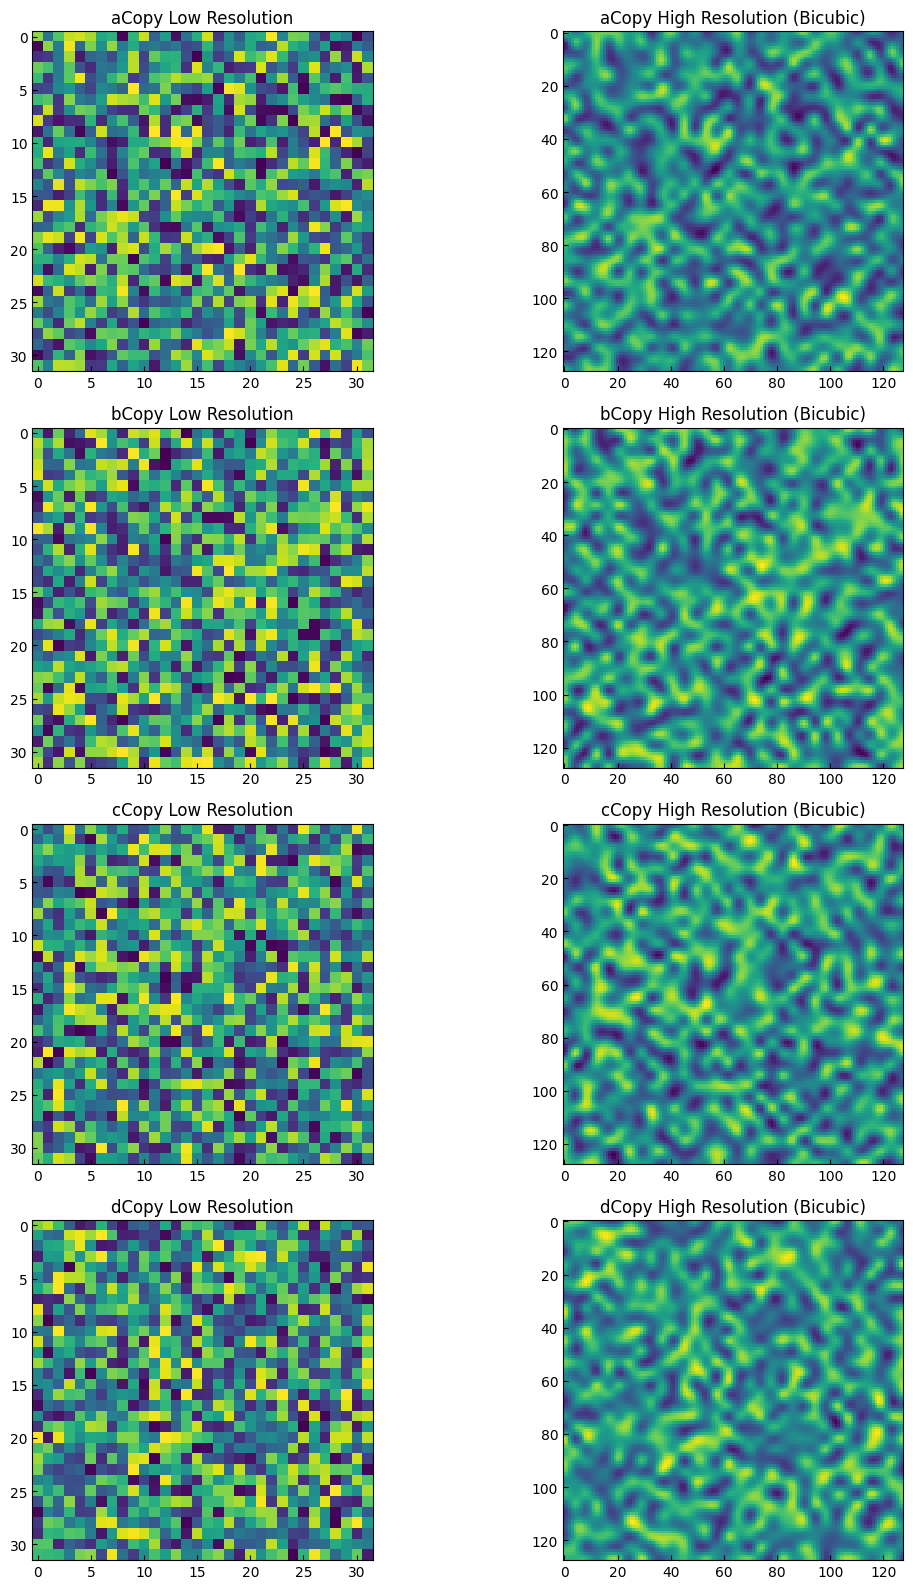

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# 示例数据
aCopy = np.random.rand(32, 32)
bCopy = np.random.rand(32, 32)
cCopy = np.random.rand(32, 32)
dCopy = np.random.rand(32, 32)

# 定义一个函数进行双三次插值
def bicubic_interpolation(data, scale_factor):
    return zoom(data, scale_factor, order=3)

# 设置放大因子
scale_factor = 4

# 对每组数据进行双三次插值
a_high_res = bicubic_interpolation(aCopy, scale_factor)
b_high_res = bicubic_interpolation(bCopy, scale_factor)
c_high_res = bicubic_interpolation(cCopy, scale_factor)
d_high_res = bicubic_interpolation(dCopy, scale_factor)

# 确认高分辨率数据的形状
print("a_high_res shape:", a_high_res.shape)
print("b_high_res shape:", b_high_res.shape)
print("c_high_res shape:", c_high_res.shape)
print("d_high_res shape:", d_high_res.shape)

# 可视化对比
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# 绘制原始低分辨率图像
axs[0, 0].imshow(aCopy, cmap='viridis', interpolation='none')
axs[0, 0].set_title('aCopy Low Resolution')
axs[1, 0].imshow(bCopy, cmap='viridis', interpolation='none')
axs[1, 0].set_title('bCopy Low Resolution')
axs[2, 0].imshow(cCopy, cmap='viridis', interpolation='none')
axs[2, 0].set_title('cCopy Low Resolution')
axs[3, 0].imshow(dCopy, cmap='viridis', interpolation='none')
axs[3, 0].set_title('dCopy Low Resolution')

# 绘制双三次插值后的高分辨率图像
axs[0, 1].imshow(a_high_res, cmap='viridis', interpolation='none')
axs[0, 1].set_title('aCopy High Resolution (Bicubic)')
axs[1, 1].imshow(b_high_res, cmap='viridis', interpolation='none')
axs[1, 1].set_title('bCopy High Resolution (Bicubic)')
axs[2, 1].imshow(c_high_res, cmap='viridis', interpolation='none')
axs[2, 1].set_title('cCopy High Resolution (Bicubic)')
axs[3, 1].imshow(d_high_res, cmap='viridis', interpolation='none')
axs[3, 1].set_title('dCopy High Resolution (Bicubic)')

plt.tight_layout()
plt.show()


## AI 算法

### SRCNN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# 定义数据集类
class ABCDFieldDataset(Dataset):
    def __init__(self, low_res_data):
        self.low_res_data = low_res_data

    def __len__(self):
        return len(self.low_res_data)

    def __getitem__(self, idx):
        return self.low_res_data[idx]

准备低分辨率数据
aCopy = a_predictions[0].squeeze().copy()
bCopy = b_predictions[0].squeeze().copy()
cCopy = c_predictions[0].squeeze().copy()
dCopy = d_predictions[0].squeeze().copy()

low_res_data = np.stack([aCopy, bCopy, cCopy, dCopy], axis=0)

# 创建 DataLoader
batch_size = 1
train_dataset = ABCDFieldDataset(torch.tensor(low_res_data).unsqueeze(1).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# 定义一个简单的超分辨率CNN模型
class SRCNN(nn.Module):
    def __init__(self, upscale_factor):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.upsample = nn.ConvTranspose2d(64, 64, kernel_size=upscale_factor, stride=upscale_factor, padding=0)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.upsample(x)
        x = self.conv3(x)
        return x

In [23]:
# 初始化模型、损失函数和优化器
upscale_factor = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRCNN(upscale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


In [34]:
# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for low_res in train_loader:
        low_res = low_res.to(device)
        high_res = torch.nn.functional.interpolate(low_res, scale_factor=upscale_factor, mode='bilinear', align_corners=False)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * low_res.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    scheduler.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/1000, Loss: 0.0001
Epoch 2/1000, Loss: 0.0001
Epoch 3/1000, Loss: 0.0001
Epoch 4/1000, Loss: 0.0001
Epoch 5/1000, Loss: 0.0001
Epoch 6/1000, Loss: 0.0001
Epoch 7/1000, Loss: 0.0001
Epoch 8/1000, Loss: 0.0001
Epoch 9/1000, Loss: 0.0001
Epoch 10/1000, Loss: 0.0001
Epoch 11/1000, Loss: 0.0001
Epoch 12/1000, Loss: 0.0001
Epoch 13/1000, Loss: 0.0001
Epoch 14/1000, Loss: 0.0001
Epoch 15/1000, Loss: 0.0001
Epoch 16/1000, Loss: 0.0001
Epoch 17/1000, Loss: 0.0001
Epoch 18/1000, Loss: 0.0001
Epoch 19/1000, Loss: 0.0001
Epoch 20/1000, Loss: 0.0001
Epoch 21/1000, Loss: 0.0001
Epoch 22/1000, Loss: 0.0001
Epoch 23/1000, Loss: 0.0001
Epoch 24/1000, Loss: 0.0001
Epoch 25/1000, Loss: 0.0001
Epoch 26/1000, Loss: 0.0001
Epoch 27/1000, Loss: 0.0001
Epoch 28/1000, Loss: 0.0001
Epoch 29/1000, Loss: 0.0001
Epoch 30/1000, Loss: 0.0001
Epoch 31/1000, Loss: 0.0001
Epoch 32/1000, Loss: 0.0001
Epoch 33/1000, Loss: 0.0001
Epoch 34/1000, Loss: 0.0001
Epoch 35/1000, Loss: 0.0001
Epoch 36/1000, Loss: 0.0001
E

In [35]:
# 测试模型
model.eval()
with torch.no_grad():
    low_res_sample = torch.tensor(low_res_data).unsqueeze(1).float().to(device)
    output_sample = model(low_res_sample).cpu().numpy()

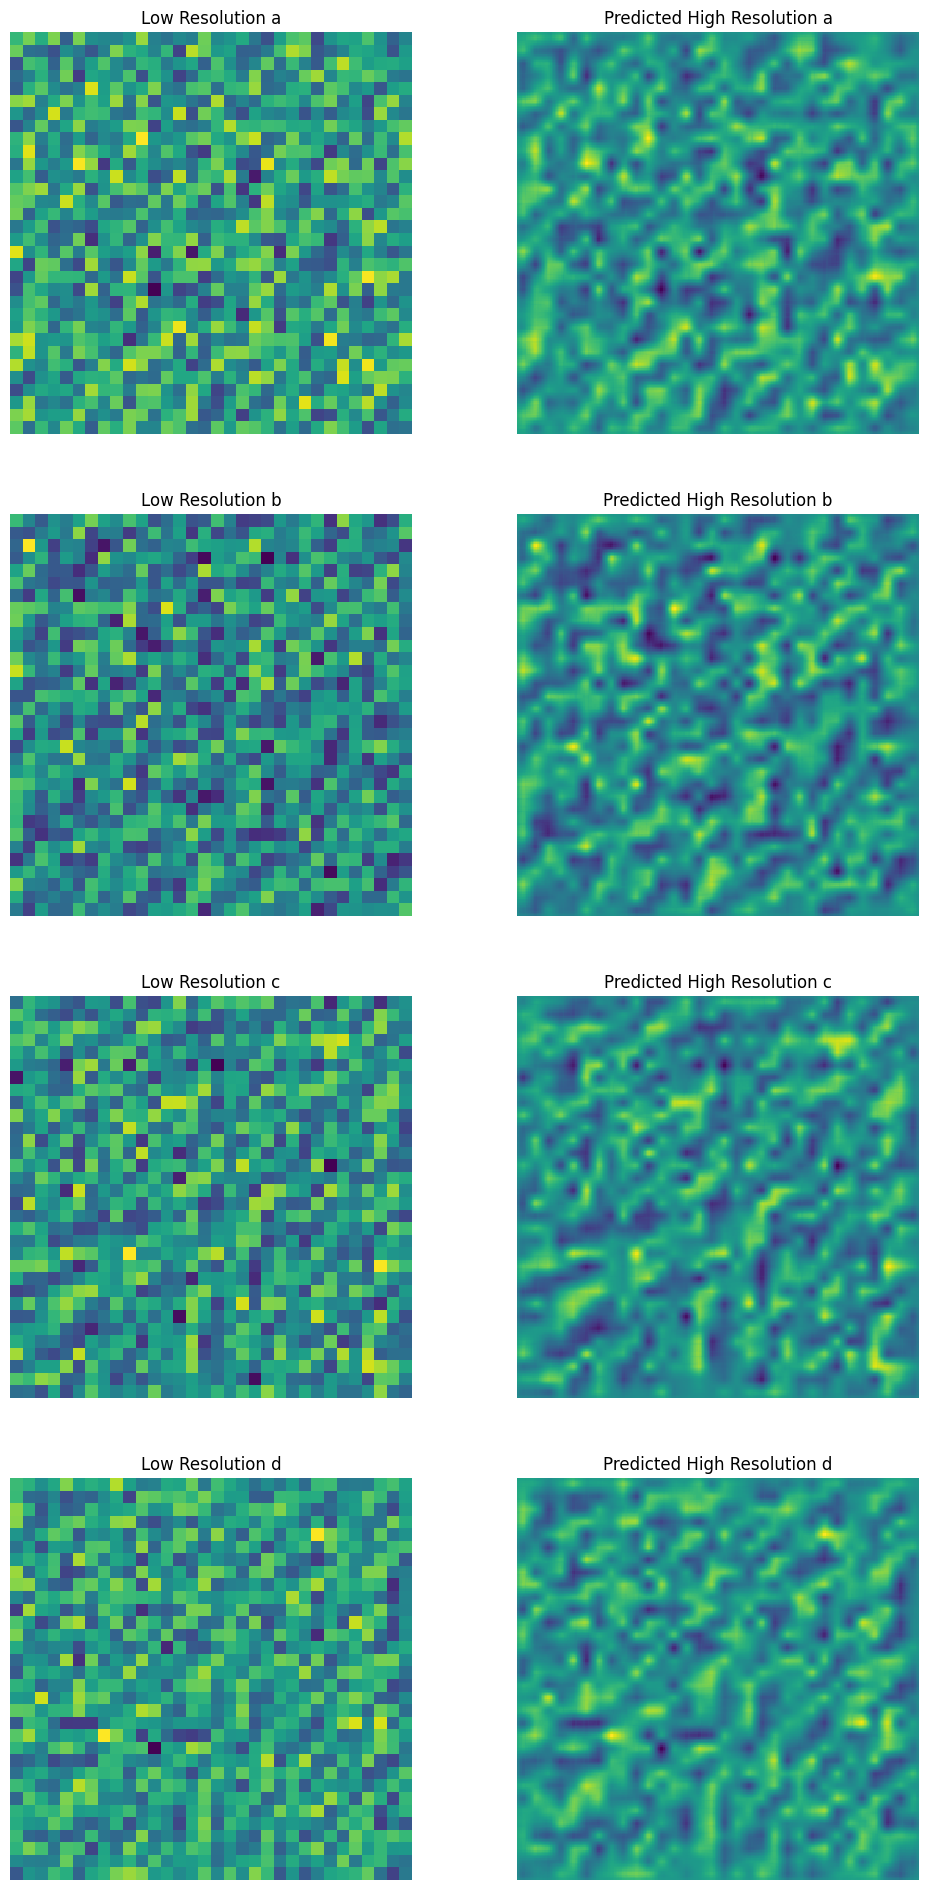

In [36]:
# 可视化结果
fig, axs = plt.subplots(4, 2, figsize=(12, 24))

fields = ['a', 'b', 'c', 'd']
for i in range(4):
    axs[i, 0].imshow(low_res_data[i], cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f'Low Resolution {fields[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(output_sample[i][0], cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f'Predicted High Resolution {fields[i]}')
    axs[i, 1].axis('off')

plt.show()

In [37]:
a_high_res = output_sample[0][0]
b_high_res = output_sample[1][0]
c_high_res = output_sample[2][0]
d_high_res = output_sample[3][0]

a_high_res.shape, b_high_res.shape, c_high_res.shape, d_high_res.shape

((256, 256), (256, 256), (256, 256), (256, 256))

In [38]:
sizeLow = 32
xlow = np.linspace(-np.pi, np.pi, sizeLow)
tlow = np.linspace(0, 10, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 256
xHigh = np.linspace(-np.pi, np.pi, sizehigh)
tHigh = np.linspace(0, 10, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [39]:
u_low = compute_u(aCopy, bCopy, cCopy, dCopy, dxLow)

a_high = output_sample[0, 0]
b_high = output_sample[1, 0]
c_high = output_sample[2, 0]
d_high = output_sample[3, 0]

u_high = compute_u(a_high_res, b_high_res, c_high_res, d_high_res, dxHigh)


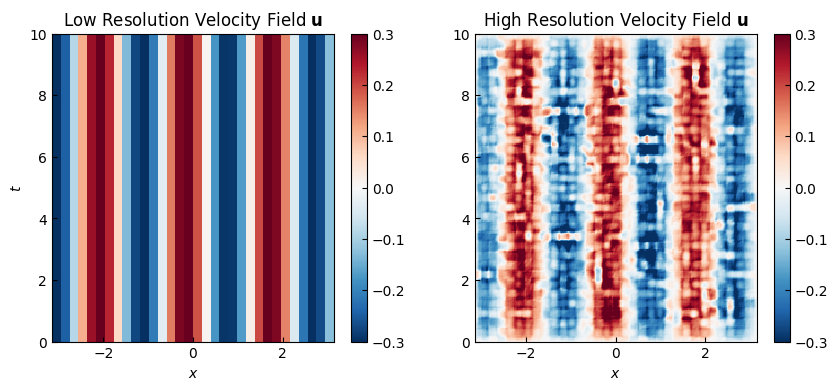

In [51]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Low Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.title('High Resolution Velocity Field $\\mathbf{u}$')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

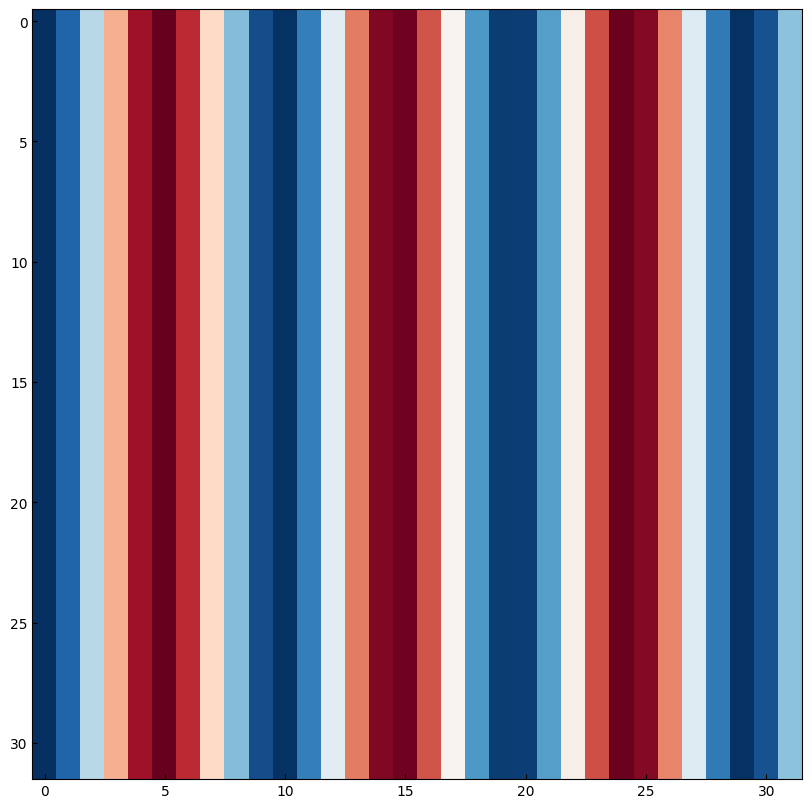

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(u_low, interpolation='none', cmap='RdBu_r')

In [54]:
u_low.shape

(32, 32)

### ClycleGan

In [1]:
import paddle as pd
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")

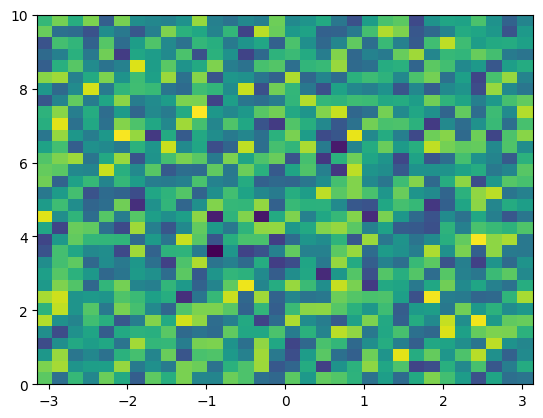

In [6]:
plt.imshow(aCopy, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

In [13]:
aCopy

array([[ 0.06015105,  0.12759589,  0.03761138, ..., -0.02071459,
        -0.12401037, -0.05144067],
       [ 0.11713569, -0.09538069, -0.10238245, ..., -0.01125342,
        -0.15365916, -0.00621982],
       [-0.15474495,  0.08036683,  0.05674074, ...,  0.02958925,
         0.0343495 ,  0.00968266],
       ...,
       [-0.01099912,  0.15470052, -0.08156231, ..., -0.02412529,
        -0.1257666 , -0.03673694],
       [ 0.13199848,  0.16611508, -0.01669646, ..., -0.14590739,
        -0.06455505,  0.03498148],
       [ 0.10453318, -0.09580866,  0.06299143, ...,  0.0172102 ,
        -0.09753132, -0.08616719]], dtype=float32)

In [14]:
# 定义生成器模型
class GeneratorG(nn.Layer):
    def __init__(self):
        super(GeneratorG, self).__init__()
        self.conv1 = nn.Conv2D(1, 64, 9, padding=4)
        self.conv2 = nn.Conv2D(64, 32, 5, padding=2)
        self.upsample = nn.Conv2DTranspose(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2D(32, 1, 5, padding=2)

    def forward(self, x):
        x = paddle.nn.functional.relu(self.conv1(x))
        x = paddle.nn.functional.relu(self.conv2(x))
        x = paddle.nn.functional.relu(self.upsample(x))
        x = self.conv3(x)
        return x


In [15]:
# 初始化模型
genG = GeneratorG()

# 加载预训练模型权重
model_path = "saved_models/genG.pdparams"
genG.set_state_dict(paddle.load(model_path))
genG.eval()

# 加载低分辨率数据
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")


In [17]:
low_res_data = np.stack([aCopy, bCopy, cCopy, dCopy], axis=0)
low_res_data = paddle.to_tensor(low_res_data).astype('float32').unsqueeze(1)  # 添加通道维度


In [22]:
with paddle.no_grad():
    high_res_data = genG(low_res_data)

# 确认输出尺寸是否正确
print(high_res_data.shape)



[4, 1, 64, 64]


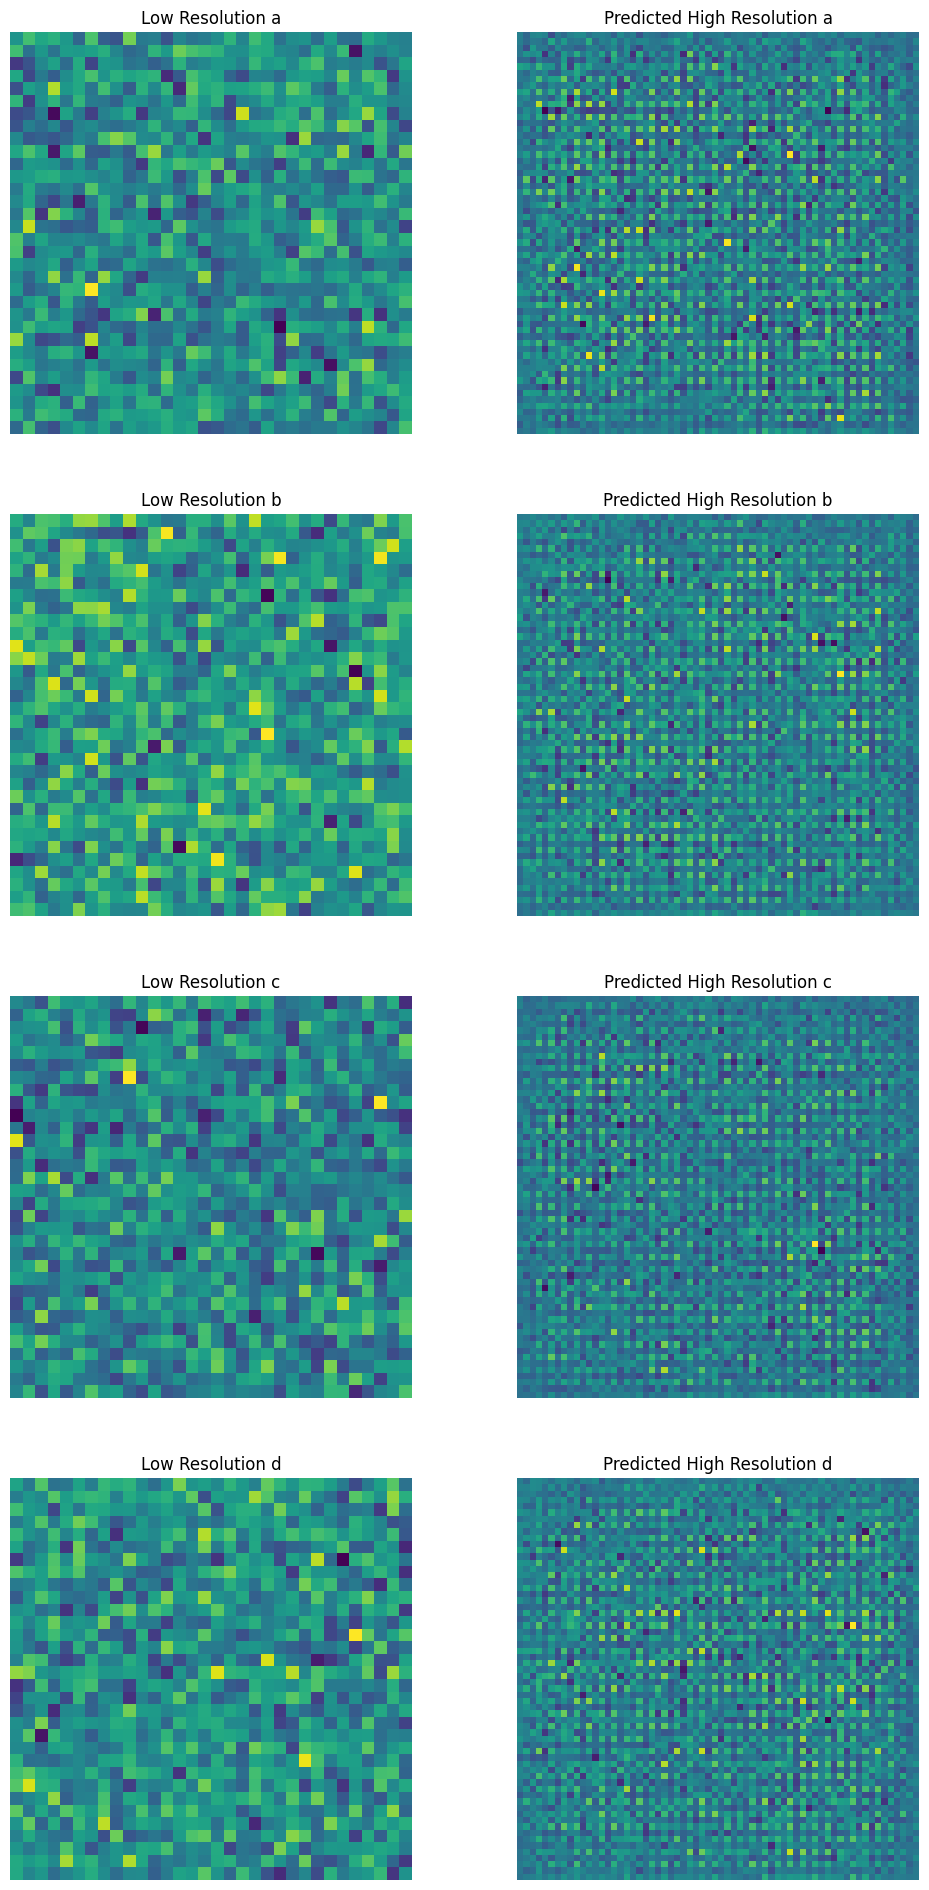

In [23]:
# 可视化结果
high_res_data = high_res_data.numpy()

fig, axs = plt.subplots(4, 2, figsize=(12, 24))

fields = ['a', 'b', 'c', 'd']
for i in range(4):
    axs[i, 0].imshow(low_res_data[i, 0], cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f'Low Resolution {fields[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(high_res_data[i, 0], cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f'Predicted High Resolution {fields[i]}')
    axs[i, 1].axis('off')

plt.show()

In [25]:
sizeLow = 32
xlow = np.linspace(-np.pi, np.pi, sizeLow)
tlow = np.linspace(0, 10, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 64
xHigh = np.linspace(-np.pi, np.pi, sizehigh)
tHigh = np.linspace(0, 10, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [26]:
u_low = compute_u(aCopy, bCopy, cCopy, dCopy, dxLow)

a_high = high_res_data[0, 0]
b_high = high_res_data[1, 0]
c_high = high_res_data[2, 0]
d_high = high_res_data[3, 0]

u_high = compute_u(a_high, b_high, c_high, d_high, dxHigh)


ValueError: operands could not be broadcast together with shapes (64,64) (32,32) 

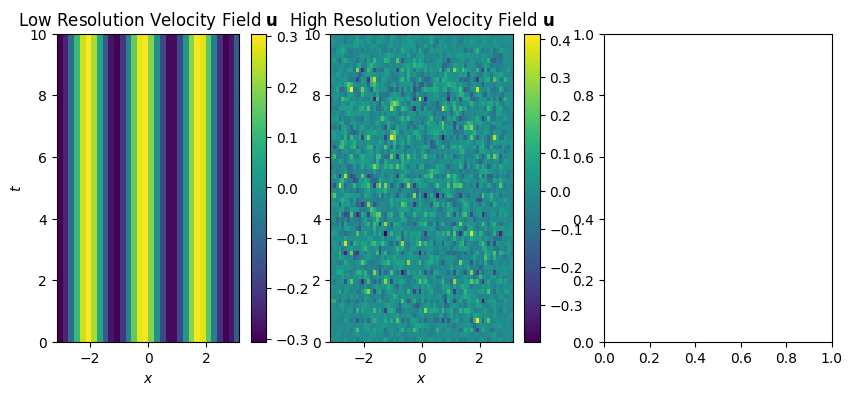

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Low Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 2)
plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('$x$')
plt.title('High Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 3)
plt.imshow(u_high - u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('$x$')
plt.title('Difference $\\mathbf{u}_{high} - \\mathbf{u}_{low}$')

plt.tight_layout()
plt.show()


# 二维算例

In [94]:
import numpy as np
import matplotlib.pyplot as plt


In [95]:
# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算梯度
def gradient(f, x, y, eps=1e-5):
    f_x = (f(x + eps, y) - f(x - eps, y)) / (2 * eps)
    f_y = (f(x, y + eps) - f(x, y - eps)) / (2 * eps)
    return f_x, f_y

# 计算速度场
def compute_velocity_field_np(x, y, dx, dy):
    # 使用内置的np 求解梯度
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
    b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
    c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
    d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

def compute_velocity_field_FD(x, y):
    # 有限差分进行计算
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = gradient(a, x, y)
    b_grad_x, b_grad_y = gradient(b, x, y)
    c_grad_x, c_grad_y = gradient(c, x, y)
    d_grad_x, d_grad_y = gradient(d, x, y)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

In [96]:
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
X, Y = np.meshgrid(x, y)

In [97]:
# 计算函数值
A = a(X, Y)
B = b(X, Y)
C = c(X, Y)
D = d(X, Y)

In [98]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]

In [99]:
U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)

U_x_FD, U_y_FD = compute_velocity_field_FD(X, Y)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2)

U_magnitude_FD = np.sqrt(U_x_FD**2 + U_y_FD**2)

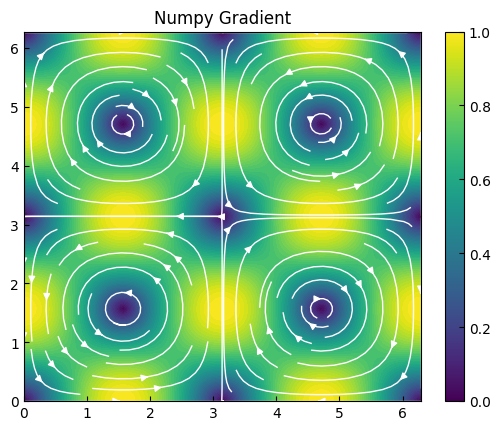

In [103]:
plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
# plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('Numpy Gradient')
plt.streamplot(X, Y, U_x_FD, U_y_FD, color='white', linewidth=1)
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.colorbar()


In [104]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

In [105]:
# 计算旋度
vort = vorticity(U_x, U_y, dx, dy)
vort_FD = vorticity(U_x_FD, U_y_FD, dx, dy)

# 归一化旋度
max_vort = np.max(np.abs(vort))
vort_normalized = vort / max_vort if max_vort != 0 else vort

max_vort_FD = np.max(np.abs(vort_FD))
vort_normalized_FD = vort_FD / max_vort_FD if max_vort_FD != 0 else vort_FD



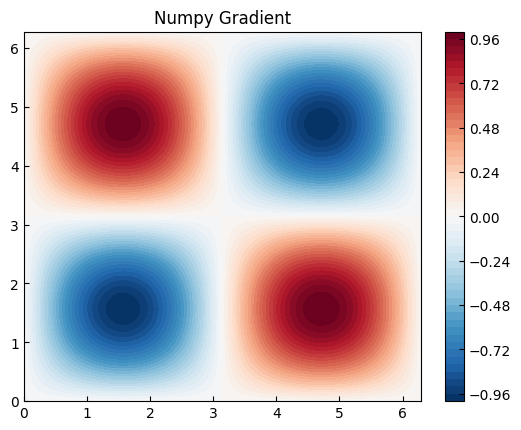

In [111]:

plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Numpy Gradient')
plt.colorbar()

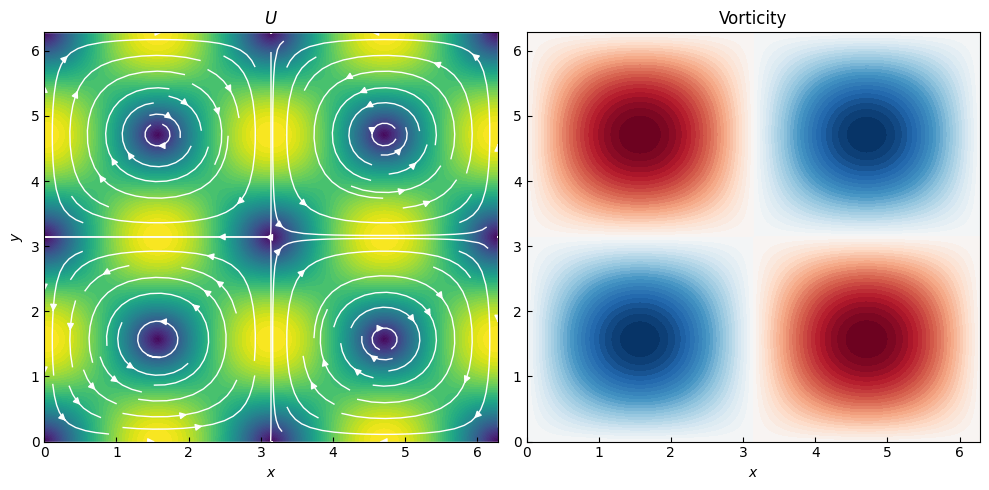

In [119]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
# plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('$U$')
plt.streamplot(X, Y, U_x_FD, U_y_FD, color='white', linewidth=1)
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(1, 2, 2)
plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Vorticity')
plt.xlabel('$x$')

plt.tight_layout()
plt.savefig('result/velocity_field_vorticity.png', dpi=500)
plt.show()


